In [6]:
from molecular_mpns.config import data_dir
import numpy as np 
import mdtraj as md
import os
from torch_geometric.nn.models.dimenet import DimeNet
from molecular_mpns.data import AlanineDipeptideGraph
from torch_geometric.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

In [11]:
# load training trajectory
os.chdir(data_dir)
os.chdir('alanine_dipeptide/')
xtc_file = 'alanine-dipeptide-0-250ns-nowater.xtc'
top_file = 'alanine-dipeptide-nowater.pdb'
traj = md.load(xtc_file,top=top_file)
traj = traj.superpose(traj)

# create graphs
batch_size = 32
z = [atom.element.atomic_number for atom in traj.topology.atoms]
G = [AlanineDipeptideGraph(z = torch.tensor(z).long(),pos = torch.tensor(xyz)) for xyz in traj.xyz]

In [15]:
# define model
class VAE(torch.nn.Module):
    
    def __init__(self,hidden_channels, out_channels, num_blocks, num_bilinear,
                 num_spherical, num_radial, cutoff, zdim=2, xdim = 22*3,training = True):
        
        super(VAE,self).__init__()
        
        d1,d2,d3 = 256,256,256 # hidden dimensions in network
        self.training = training
        
        # encoder
        self.mpn = DimeNet(hidden_channels, out_channels, num_blocks, num_bilinear,
                 num_spherical, num_radial, cutoff=cutoff)
        
        self.enc_lin1 = torch.nn.Linear(out_channels, out_channels)
        self.enc_lin2 = torch.nn.Linear(out_channels, out_channels)
        self.enc_lin3 = torch.nn.Linear(out_channels, out_channels)
        self.enc_lin4 = torch.nn.Linear(out_channels, out_channels)
        
        self.enc_mu = torch.nn.Linear(out_channels,zdim)
        self.enc_logvar = torch.nn.Linear(out_channels,zdim)
    
        # decoder
        self.dec_lin1 = torch.nn.Linear(zdim,d1)
        self.dec_lin2 = torch.nn.Linear(d1,d2)
        self.dec_lin3 = torch.nn.Linear(d2,d2)
        self.dec_lin4 = torch.nn.Linear(d2,d2)
        
        #self.dec_logvar = torch.nn.Parameter(torch.zeros(xdim), requires_grad=True)
        self.dec_logvar = torch.nn.Linear(d2,xdim)
        self.dec_mu = torch.nn.Linear(d2,xdim)
        
    def encode(self,G_batch):
        
        h = self.mpn(G_batch.z,G_batch.pos,G_batch.batch)
        h = self.enc_lin1(h)
        h = torch.tanh(h)
        h = self.enc_lin2(h)
        h = torch.tanh(h)
        h = self.enc_lin3(h)
        h = torch.tanh(h)
        h = self.enc_lin4(h)
        h = torch.tanh(h)
        
        
        mu_enc = self.enc_mu(h)
        logvar_enc = self.enc_logvar(h)
        
        return mu_enc, logvar_enc
    
    def reparameterize(self,mu_enc,mu_logvar):
        
        sigma = torch.exp(0.5*mu_logvar)
        eps = torch.randn_like(sigma)
        z = mu_enc + (sigma*eps)
        
        return z if self.training else mu_enc
    
    def decode(self,z):
        
        h = self.dec_lin1(z)
        h = torch.tanh(h)
        h = self.dec_lin2(h)
        h = torch.tanh(h)
        h = self.dec_lin3(h)
        h = torch.tanh(h)
        h = self.dec_lin4(h)
        h = torch.tanh(h)
        
        mu_dec = self.dec_mu(h)
        
        #batch_size = mu_dec.shape[0]
        #logvar_dec = self.dec_logvar.repeat(batch_size, 1)
        logvar_dec = self.dec_logvar(h)
        
        return mu_dec, logvar_dec
    
    def forward(self, G_batch):
        mu_enc, logvar_enc = self.encode(G_batch)
        z = self.reparameterize(mu_enc, logvar_enc)
        return self.decode(z), mu_enc, logvar_enc
    
def VAEloss(mu_dec,logvar_dec,G_batch,mu_enc,logvar_enc,L):
    
    # recon loss for p(x | z)
    data = G_batch.pos.view(mu_dec.shape[0],mu_dec.shape[1])
    pointwiseMSEloss = 0.5*torch.nn.functional.mse_loss(mu_dec,data,reduction = 'none')
    sigsq = torch.exp(logvar_dec)
    weight = 1/sigsq
    pointwiseWeightedMSEloss = pointwiseMSEloss*weight
    WeightedMSEloss = pointwiseWeightedMSEloss.sum()
    
    logvarobjective = 0.5 * logvar_dec.sum() # scaling factor term for p(x|z)
    
    # KLD loss for q(z | x)
    KLD = -0.5 * torch.sum(1 + logvar_enc - mu_enc**2 - torch.exp(logvar_enc))
    
    loss = (KLD + (1/L)*WeightedMSEloss + logvarobjective)
    
    return loss

In [16]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_channels, out_channels, num_blocks, num_bilinear, num_spherical, num_radial, cutoff = 128, 128, 2, 8, 6, 6, 5
mod = VAE(hidden_channels, out_channels, num_blocks, num_bilinear, num_spherical, num_radial, cutoff)
mod = mod.to(device)

opt = torch.optim.Adam(mod.parameters(),lr = 1e-7, weight_decay = 1e-5)
sched = ExponentialLR(opt, gamma = 0.995)

Epoch 25 Loss: 62983.59017944336


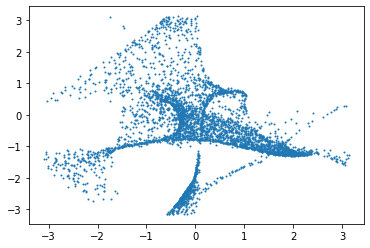

Epoch 50 Loss: 62026.00717163086


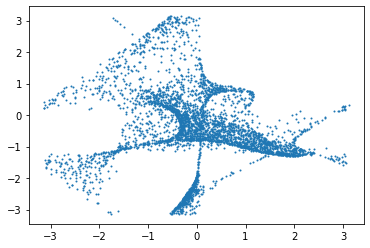

Epoch 75 Loss: 61147.55499267578


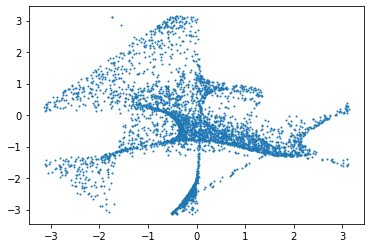

Epoch 100 Loss: 60285.181213378906


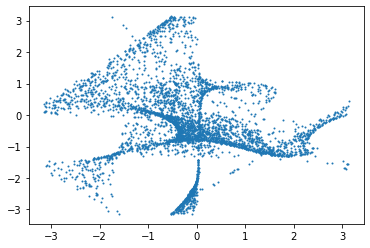

Epoch 125 Loss: 59234.778411865234


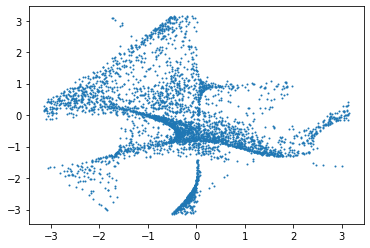

Epoch 150 Loss: 58028.19421386719


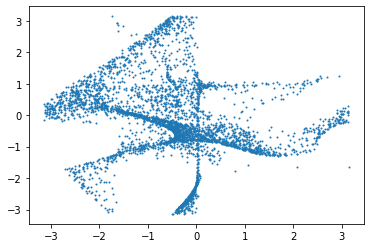

Epoch 175 Loss: 57101.68176269531


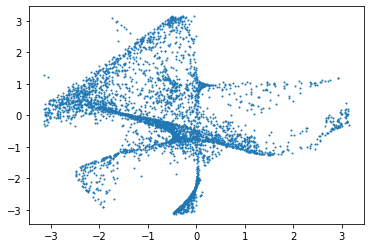

Epoch 200 Loss: 55911.661712646484


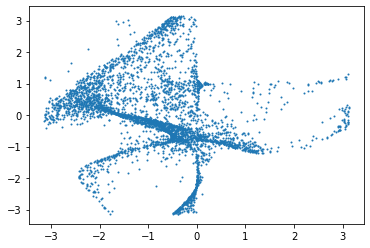

Epoch 225 Loss: 54702.4948425293


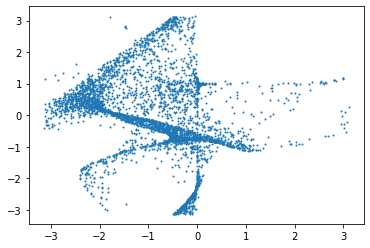

Epoch 250 Loss: 53521.51565551758


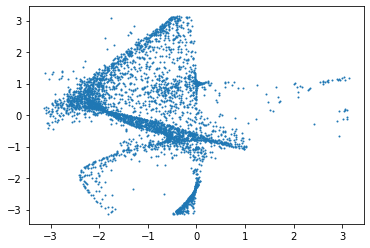

Epoch 275 Loss: 52372.84094238281


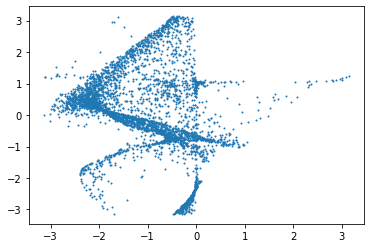

Epoch 300 Loss: 51135.74786376953


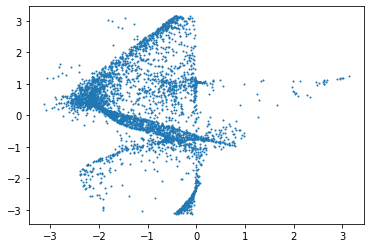

Epoch 325 Loss: 49641.08102416992


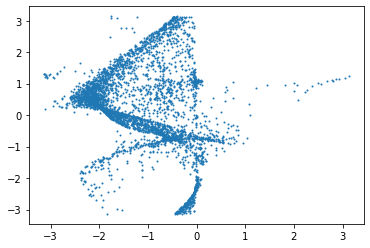

Epoch 350 Loss: 48312.85876464844


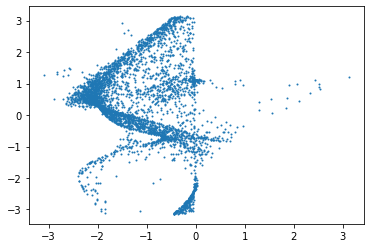

Epoch 375 Loss: 46720.78918457031


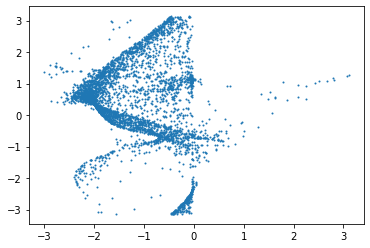

Epoch 400 Loss: 45403.043853759766


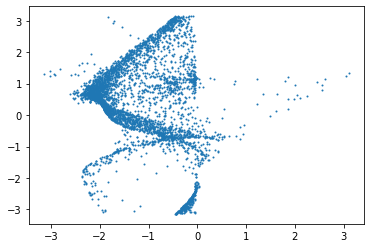

Epoch 425 Loss: 43985.50198364258


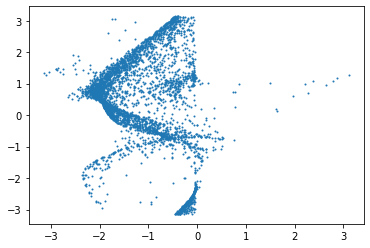

Epoch 450 Loss: 42440.38262939453


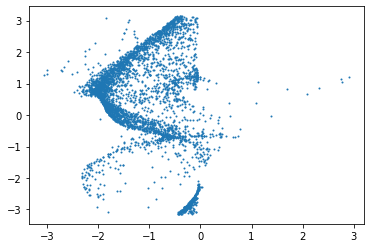

Epoch 475 Loss: 40897.1083984375


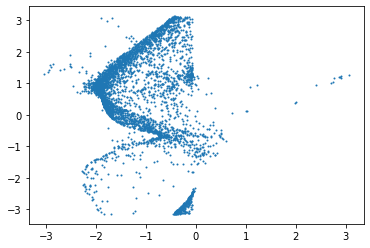

KeyboardInterrupt: 

In [17]:
# train
epochs, batch_size = 1000, 32

for ep in range(epochs):
    ep_loss = 0
    
    # downsample training set
    random_idx = np.random.choice(len(G),1000, replace = False)
    G_epoch = [G[i] for i in random_idx]
    loader = DataLoader(G_epoch,batch_size = batch_size)
    
    for G_batch in loader:
        G_batch.to(device)
        
        # forward pass
        recon_batch, mu_enc, logvar_enc = mod(G_batch)
        mu_dec = recon_batch[0]
        logvar_dec = recon_batch[1]
        
        # compute loss
        loss = VAEloss(mu_dec,logvar_dec,G_batch,mu_enc,logvar_enc,L=1)
        
        # back prop
        loss.backward()
        opt.step()
        opt.zero_grad()
        ep_loss += loss.item()
    
    if (ep+1) % 25 == 0:
    
        print("Epoch " + str(ep + 1) + " Loss: " + str(ep_loss))
        
        val_size = 4000
        
        z = torch.randn((val_size,2))
        with torch.no_grad():
            x_recon, _ = mod.decode(z.to(device))
        
        x_np = x_recon.cpu().numpy()
        x_np = x_np.reshape((val_size,22,3))
        val_traj = md.Trajectory(xyz = x_np,topology = traj.topology)
        psi_inds, phi_inds = [6, 8, 14, 16], [4, 6, 8, 14]
        dihedrals = md.compute_dihedrals(val_traj,[psi_inds,phi_inds])  
        plt.scatter(dihedrals[:,1],dihedrals[:,0],s = 1)
        plt.show()
        plt.close()